# Projeto Machine Learning II – Classificação de Sons Urbanos

## 1. Contexto
O som urbano faz parte essencial do ambiente em que vivemos. A classificação automática de sons urbanos (como buzinas, sirenes ou crianças a brincar) é relevante para aplicações em **segurança**, **monitorização ambiental**, **cidades inteligentes** e **recuperação de multimédia**. Apesar da extensa pesquisa em áudio, poucos trabalhos lidam com **sons urbanos reais**, e a ausência de datasets padronizados dificulta a comparação de resultados.

## 2. Objetivo do Projeto
O objetivo deste projeto é desenvolver **classificadores de deep learning** capazes de identificar a qual das 10 classes pertence um trecho de áudio urbano. Para isso, serão implementados dois modelos de redes neurais à escolha entre **MLP, CNN e RNN**, permitindo avaliar e comparar o desempenho de cada um.

## 3. Dataset UrbanSound8K

### 3.1. Dataset metadata

- **slice_file_name**: O nome do ficheiro de áudio.
- **fsID**: O ID do Freesound da gravação de onde este excerto (slice) foi retirado.
- **start**: O momento inicial do excerto na gravação original do Freesound.
- **end**: O momento final do excerto na gravação original do Freesound.
- **salience**: Uma classificação (subjetiva) da importância do som.  
  - **1** = som em primeiro plano  
  - **2** = som de fundo
- **fold**: O número do *fold* (1–10) ao qual este ficheiro foi atribuído (usado em divisões de treino/teste).
- **classID**: Um identificador numérico da classe do som.
- **class**: O nome da classe do som (a etiqueta que descreve o tipo de som).


### 3.2 Propriedades do áudio digital

As principais características que descrevem áudio digital — e que queremos analisar neste notebook — são:

- **Canais**: número de canais de áudio (mono/estéreo).
- **Taxa de Amostragem (Sample Rate)**: número de amostras por segundo, expresso em quilohertz (kHz); está relacionado com a qualidade do áudio.
- **Profundidade de Bits (Bit Depth)**: equivalente à resolução em imagens; descreve o nível de detalhe.
- **Duração**: comprimento do som ao longo do tempo.

As várias propriedades do áudio apresentam formatos e estruturas distintos. O primeiro passo é perceber como cada uma delas se distribui no conjunto de dados e analisar de que forma podemos padronizá-las, por exemplo, convertendo-as.






In [154]:
#bibliotecas 

import librosa 
import glob
import numpy as np
import soundata
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import os, json
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import random
import soundfile as sf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, mixed_precision
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa.display


import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import seaborn as sns 


### 1. Exploratory Data Analysis – EDA

Nesta etapa, o objetivo é compreender melhor a estrutura e as características do conjunto de dados UrbanSound8K, verificando o tipo de informações disponíveis, se há valores ausentes, e como as classes estão distribuídas.
Isso é essencial para preparar o dataset antes de qualquer modelagem.

In [5]:
dataset = soundata.initialize('urbansound8k')
#dataset.download(force_overwrite=True)
#dataset.validate()
print(os.listdir(os.path.join(dataset.data_home)))
print(os.listdir(os.path.join(dataset.data_home, "audio")))
dataset_path = os.path.join(dataset.data_home, "audio")  # Agora é uma string de caminho  #Diretório dos ficheiros áudio
print("Dataset path:", dataset.data_home)

# Caminho para o CSV
metadata_path = os.path.join(dataset.data_home, "metadata", "UrbanSound8K.csv")
print("CSV path:", metadata_path)

# Ler o CSV
metadata = pd.read_csv(metadata_path)
metadata.head()

['audio', 'FREESOUNDCREDITS.txt', 'metadata', 'UrbanSound8K.tar.gz', 'UrbanSound8K_README.txt']
['.DS_Store', 'fold1', 'fold10', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9']
Dataset path: /tmp\sound_datasets\urbansound8k
CSV path: /tmp\sound_datasets\urbansound8k\metadata\UrbanSound8K.csv


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
# nameofclass = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

#### 1.1- Estatísticas Descritivas 
Fornece informações como médias, valores mínimos e máximos e quartis das colunas numéricas — útil para verificar a consistência dos dados, por exemplo, se start < end

In [5]:
metadata.describe()

,fsID,start,end,salience,fold,classID
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000


In [6]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


O dataset não contém valores nulos, o que facilita a preparação

In [7]:
metadata.isnull().sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

## 1.1 Análise da Distribuição das Classes

Está bem distribuido em 8 classes , mas conseguimos perceber que "car_horn" e "gun_shot" têm valores significativamente diferentes que os restantes. Pode ser um problema futuro

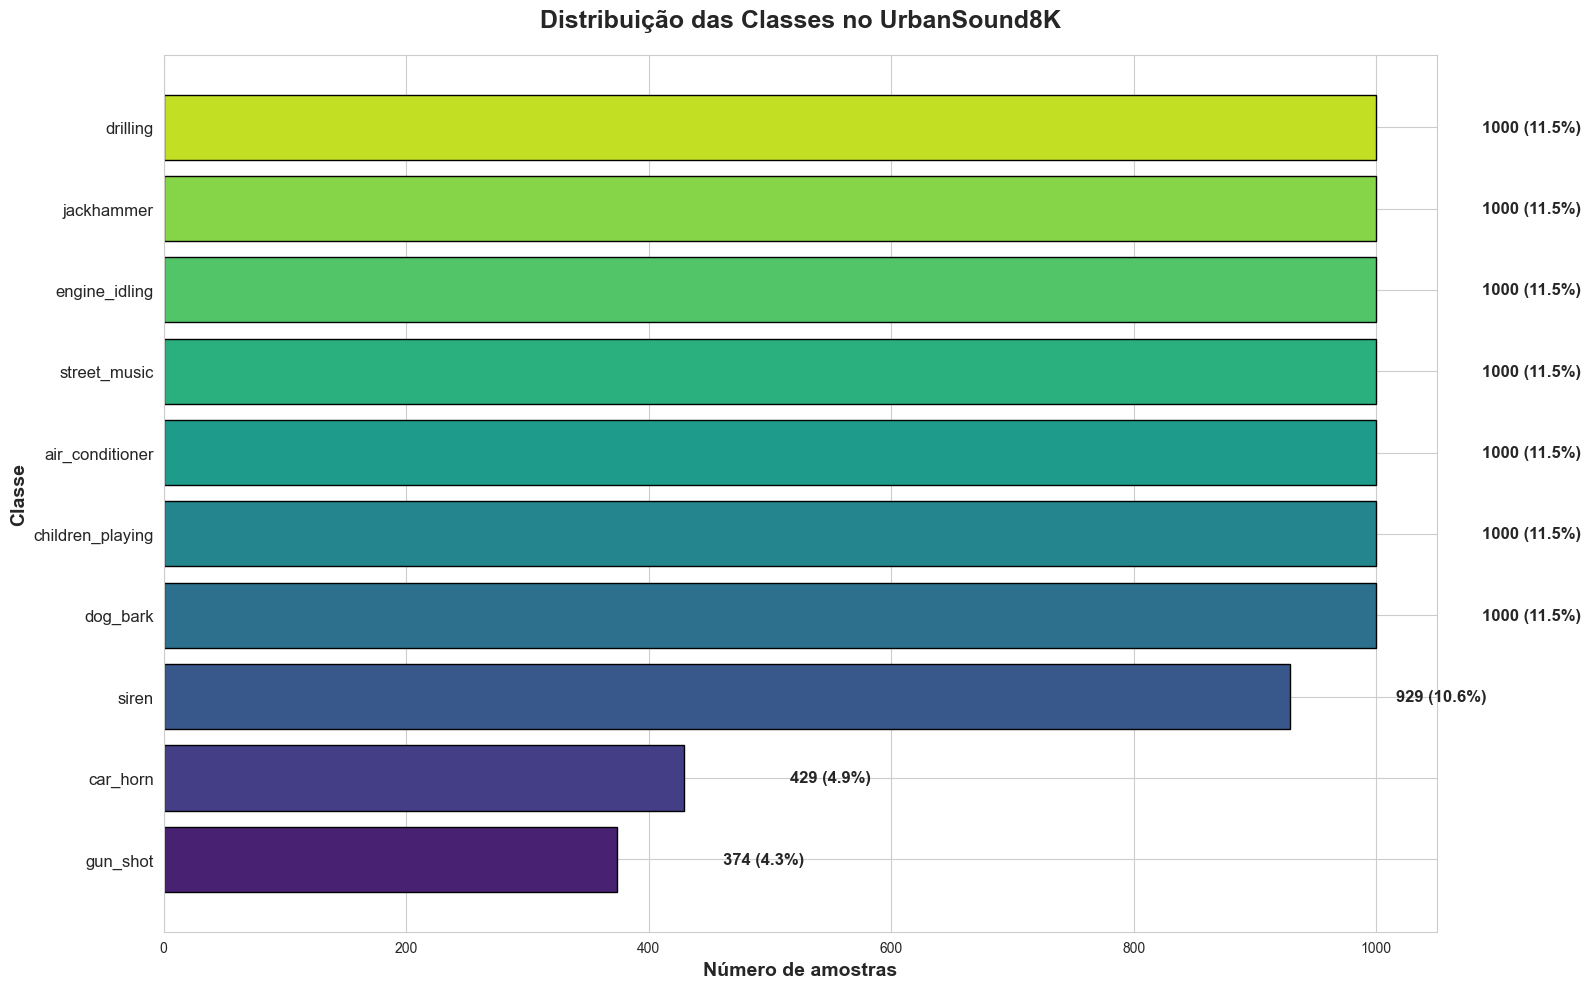

In [8]:
class_distribution = metadata['class'].value_counts().sort_values(ascending=True)
total_samples = class_distribution.sum()

plt.figure(figsize=(16, 10))  # figura maior para acomodar os nomes
sns.set_style("whitegrid")

# Paleta de cores graduais
colors = sns.color_palette("viridis", len(class_distribution))

# Criar gráfico de barras horizontais
bars = plt.barh(class_distribution.index, class_distribution.values, color=colors, edgecolor='black')

# Adicionar números e percentuais ao lado de cada barra
for bar, value in zip(bars, class_distribution.values):
    pct = value / total_samples * 100
    plt.text(value + total_samples*0.01, bar.get_y() + bar.get_height()/2, f"{value} ({pct:.1f}%)", 
             va='center', fontweight='bold', fontsize=12)

# Eixos e título
plt.xlabel("Número de amostras", fontsize=14, fontweight='bold')
plt.ylabel("Classe", fontsize=14, fontweight='bold')
plt.title("Distribuição das Classes no UrbanSound8K", fontsize=18, fontweight='bold', pad=20)

# Melhorar legibilidade dos nomes das classes
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


## 1.2 Propriedades do áudio

### 1.2.1 Comprimento do áudio

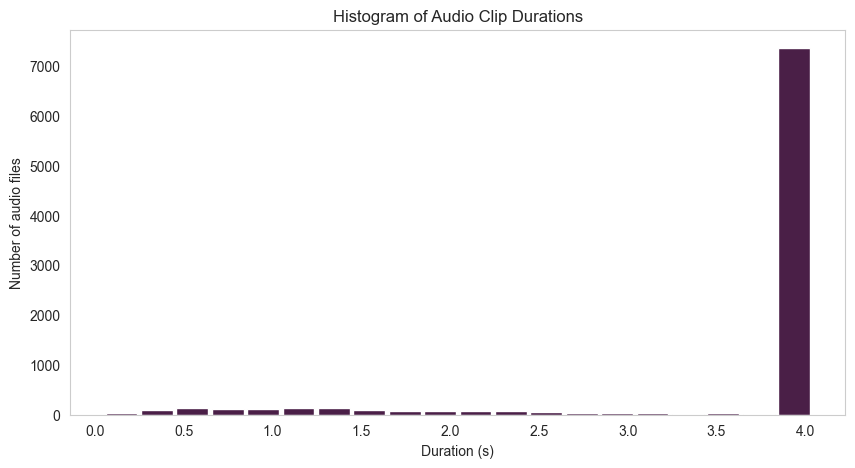

count    8732.000000
mean        3.607522
std         0.974394
min         0.050000
25%         4.000000
50%         4.000000
75%         4.000000
max         4.036647
Name: duration, dtype: float64


In [9]:
audio_durations = []

for idx, row in metadata.iterrows():
    fold = f'fold{row["fold"]}'
    file_name = str(row["slice_file_name"])
    file_path = os.path.join(dataset_path, fold, file_name)
    
    # Obtém info do ficheiro sem carregar o áudio
    info = sf.info(file_path)
    duration = info.frames / info.samplerate
    
    audio_durations.append((file_name, fold, row["class"], duration))

# Converte para DataFrame
durations_df = pd.DataFrame(audio_durations, columns=['file', 'fold', 'class', 'duration'])

# Histograma das durações
plt.figure(figsize=(10,5))
plt.hist(durations_df['duration'], bins=20, rwidth=0.9, color="#4a1f47")
plt.xlabel('Duration (s)')
plt.ylabel('Number of audio files')
plt.title('Histogram of Audio Clip Durations')
plt.grid(False)
plt.show()

# Estatísticas básicas
print(durations_df['duration'].describe())

### 1.2.2 Distribuição da frequência

In [10]:
dominant_freqs = []

for index, row in metadata.iterrows():
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    waveform, sr = librosa.load(file_path, sr=None)
    
    # FFT do sinal
    fft = np.fft.fft(waveform)
    fft_magnitude = np.abs(fft)
    fft_freqs = np.fft.fftfreq(len(fft), 1/sr)
    
    # Frequência dominante (excluindo negativas)
    pos_mask = fft_freqs > 0
    dominant_freq = fft_freqs[pos_mask][np.argmax(fft_magnitude[pos_mask])]
    dominant_freqs.append(dominant_freq)

plt.figure(figsize=(10, 5))
sns.histplot(dominant_freqs, bins=20, kde=True, color='orange')
plt.title("Distribuição da Frequência Dominante dos Clipes", fontsize=16, fontweight='bold')
plt.xlabel("Frequência (Hz)")
plt.ylabel("Frequência de ocorrência")
plt.show()

KeyboardInterrupt: 

Aqui decidimos ver a frequência mais promenorizadamente 

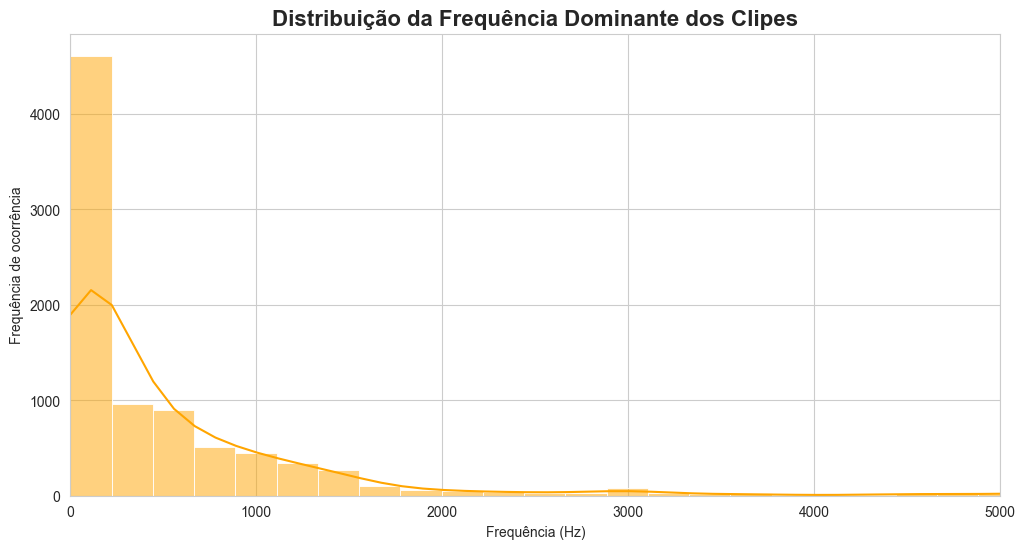

In [ ]:
dominant_freqs = []

for index, row in metadata.iterrows():
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    waveform, sr = librosa.load(file_path, sr=None)
    
    # FFT do sinal
    fft = np.fft.fft(waveform)
    fft_magnitude = np.abs(fft)
    fft_freqs = np.fft.fftfreq(len(fft), 1/sr)
    
    # Frequência dominante (excluindo negativas)
    pos_mask = fft_freqs > 0
    dominant_freq = fft_freqs[pos_mask][np.argmax(fft_magnitude[pos_mask])]
    dominant_freqs.append(dominant_freq)

plt.figure(figsize=(12, 6))
sns.histplot(dominant_freqs, bins=100, kde=True, color='orange')  # bins aumentados para mais detalhes
plt.title("Distribuição da Frequência Dominante dos Clipes", fontsize=16, fontweight='bold')
plt.xlabel("Frequência (Hz)")
plt.ylabel("Frequência de ocorrência")
plt.xlim(0, 5000)  # Limita o eixo x para melhor visualizar os detalhes mais importantes
plt.show()


### 1.2.3 Profundidade de bits

100%|██████████| 8732/8732 [00:01<00:00, 4507.02it/s]


Contagem de bit depths:
bit_depth
16.0    5758
24.0    2753
32.0     169
Name: count, dtype: int64

Proporção de bit depths:
bit_depth
16.0    0.663364
24.0    0.317166
32.0    0.019470
Name: proportion, dtype: float64


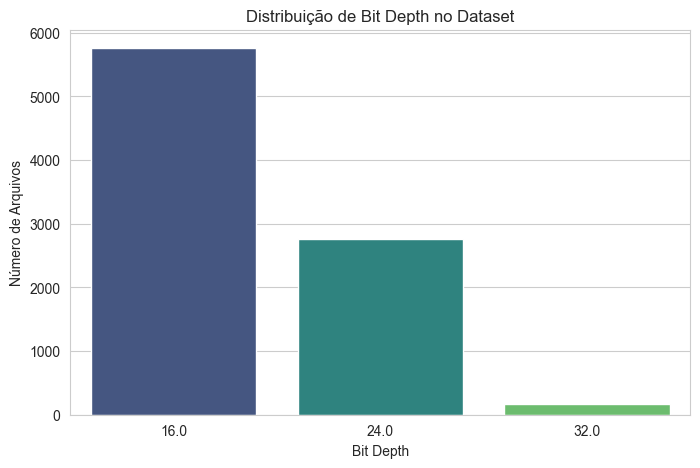

In [ ]:
def check_audio_bit_depth(metadata, dataset_path):
    """
    Verifica o bit depth de todos os arquivos do dataset.
    Retorna um DataFrame com nome do arquivo, fold e bit depth.
    """
    data = []
    
    for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
        file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
        
        # Lê informações do arquivo
        info = sf.info(file_path)
        subtype = info.subtype  # ex: 'PCM_16', 'PCM_24', 'U8', 'FLOAT', 'PCM_4'
        
        # Tenta extrair número do bit depth diretamente de qualquer string
        import re
        match = re.search(r'\d+', subtype)
        bit_depth = int(match.group()) if match else None
        
        data.append((row['slice_file_name'], row['fold'], bit_depth))
    
    df = pd.DataFrame(data, columns=['file', 'fold', 'bit_depth'])
    return df

def check_audio_bit_depth(metadata, dataset_path):
    """
    Verifica o bit depth de todos os arquivos do dataset.
    Retorna um DataFrame com nome do arquivo, fold e bit depth.
    """
    data = []

    def subtype_to_bits(subtype):
        subtype = subtype.upper()
        if subtype.startswith("PCM_"):
            try:
                return int(subtype.split("_")[1])
            except:
                return None
        elif subtype == "U8":
            return 8
        elif subtype == "FLOAT":
            return 32
        elif subtype in ["ALAW", "ULAW"]:
            return 8
        else:
            return None

    for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
        file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
        info = sf.info(file_path)
        bit_depth = subtype_to_bits(info.subtype)
        data.append((row['slice_file_name'], row['fold'], bit_depth))

    df = pd.DataFrame(data, columns=['file', 'fold', 'bit_depth'])
    return df

# Executando a função
bit_depth_info = check_audio_bit_depth(metadata, dataset_path)

# Estatísticas
print("Contagem de bit depths:")
print(bit_depth_info['bit_depth'].value_counts())
print("\nProporção de bit depths:")
print(bit_depth_info['bit_depth'].value_counts(normalize=True))

# Plot da distribuição
plt.figure(figsize=(8,5))
sns.countplot(x='bit_depth', data=bit_depth_info, palette='viridis')
plt.xlabel("Bit Depth")
plt.ylabel("Número de Arquivos")
plt.title("Distribuição de Bit Depth no Dataset")
plt.show()


### 1.2.4 Análise do Número de Canais nos Arquivos de Áudio

Cada arquivo de áudio pode ter **um ou mais canais** de som:  

- **Mono**: apenas um canal de áudio. Todos os sons são misturados em um único canal.  
- **Estéreo**: dois canais de áudio separados, normalmente representando o som para os ouvidos esquerdo e direito.  

No dataset **UrbanSound8K**, a informação sobre o número de canais **não está presente no arquivo CSV de metadata**. Portanto, precisamos inspecionar os próprios arquivos de áudio para descobrir se são mono ou estéreo.  

Para isso, podemos utilizar a biblioteca `librosa` carregando os arquivos com `mono=False`, preservando os canais originais. A forma do array retornado indica o tipo de canal:

- Se `waveform.shape` for `(n_amostras,)` → **mono**  
- Se `waveform.shape` for `(2, n_amostras)` → **estéreo**  

Com isso, podemos gerar uma **nova coluna no DataFrame** indicando o tipo de cada arquivo de áudio, o que nos permite analisar a distribuição de arquivos mono e estéreo no dataset.  

> Observação: arquivos estéreo podem ser convertidos para mono por meio de uma média entre os dois canais, técnica comum em processamento de áudio, para simplificar a entrada em modelos de aprendizado de máquina.


100%|██████████| 8732/8732 [00:01<00:00, 4870.84it/s]


Contagem de canais:
channels
2    7993
1     739
Name: count, dtype: int64

Proporção de canais:
channels
2    0.915369
1    0.084631
Name: proportion, dtype: float64


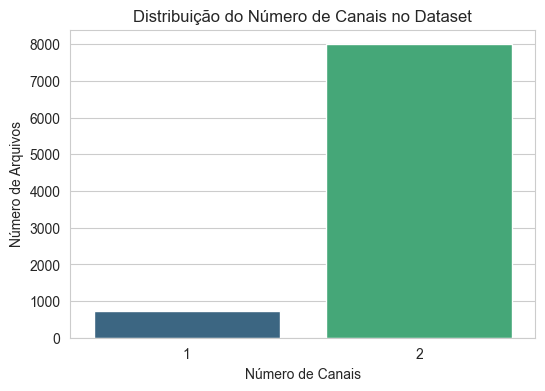

In [ ]:
def check_audio_channels(metadata, dataset_path):
    """
    Verifica o número de canais de todos os arquivos do dataset.
    Retorna um DataFrame com nome do arquivo, fold e número de canais.
    """
    data = []
    
    for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
        file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
        
        # Lê informações do arquivo
        info = sf.info(file_path)
        channels = info.channels  # Número de canais
        
        data.append((row['slice_file_name'], row['fold'], channels))
    
    df = pd.DataFrame(data, columns=['file', 'fold', 'channels'])
    return df

# Executando a função
channels_info = check_audio_channels(metadata, dataset_path)

# Estatísticas
print("Contagem de canais:")
print(channels_info['channels'].value_counts())
print("\nProporção de canais:")
print(channels_info['channels'].value_counts(normalize=True))

# Plot da distribuição de canais
plt.figure(figsize=(6,4))
sns.countplot(x='channels', data=channels_info, palette='viridis')
plt.xlabel("Número de Canais")
plt.ylabel("Número de Arquivos")
plt.title("Distribuição do Número de Canais no Dataset")
plt.show()


### 1.3 Explorar visual e auditivamente 

##### Exploração de Áudio

Visualizamos exemplos de áudio para **entender o comportamento dos sinais**, observar padrões de cada classe e orientar o **pré-processamento e extração de features** para os modelos de machine learning.


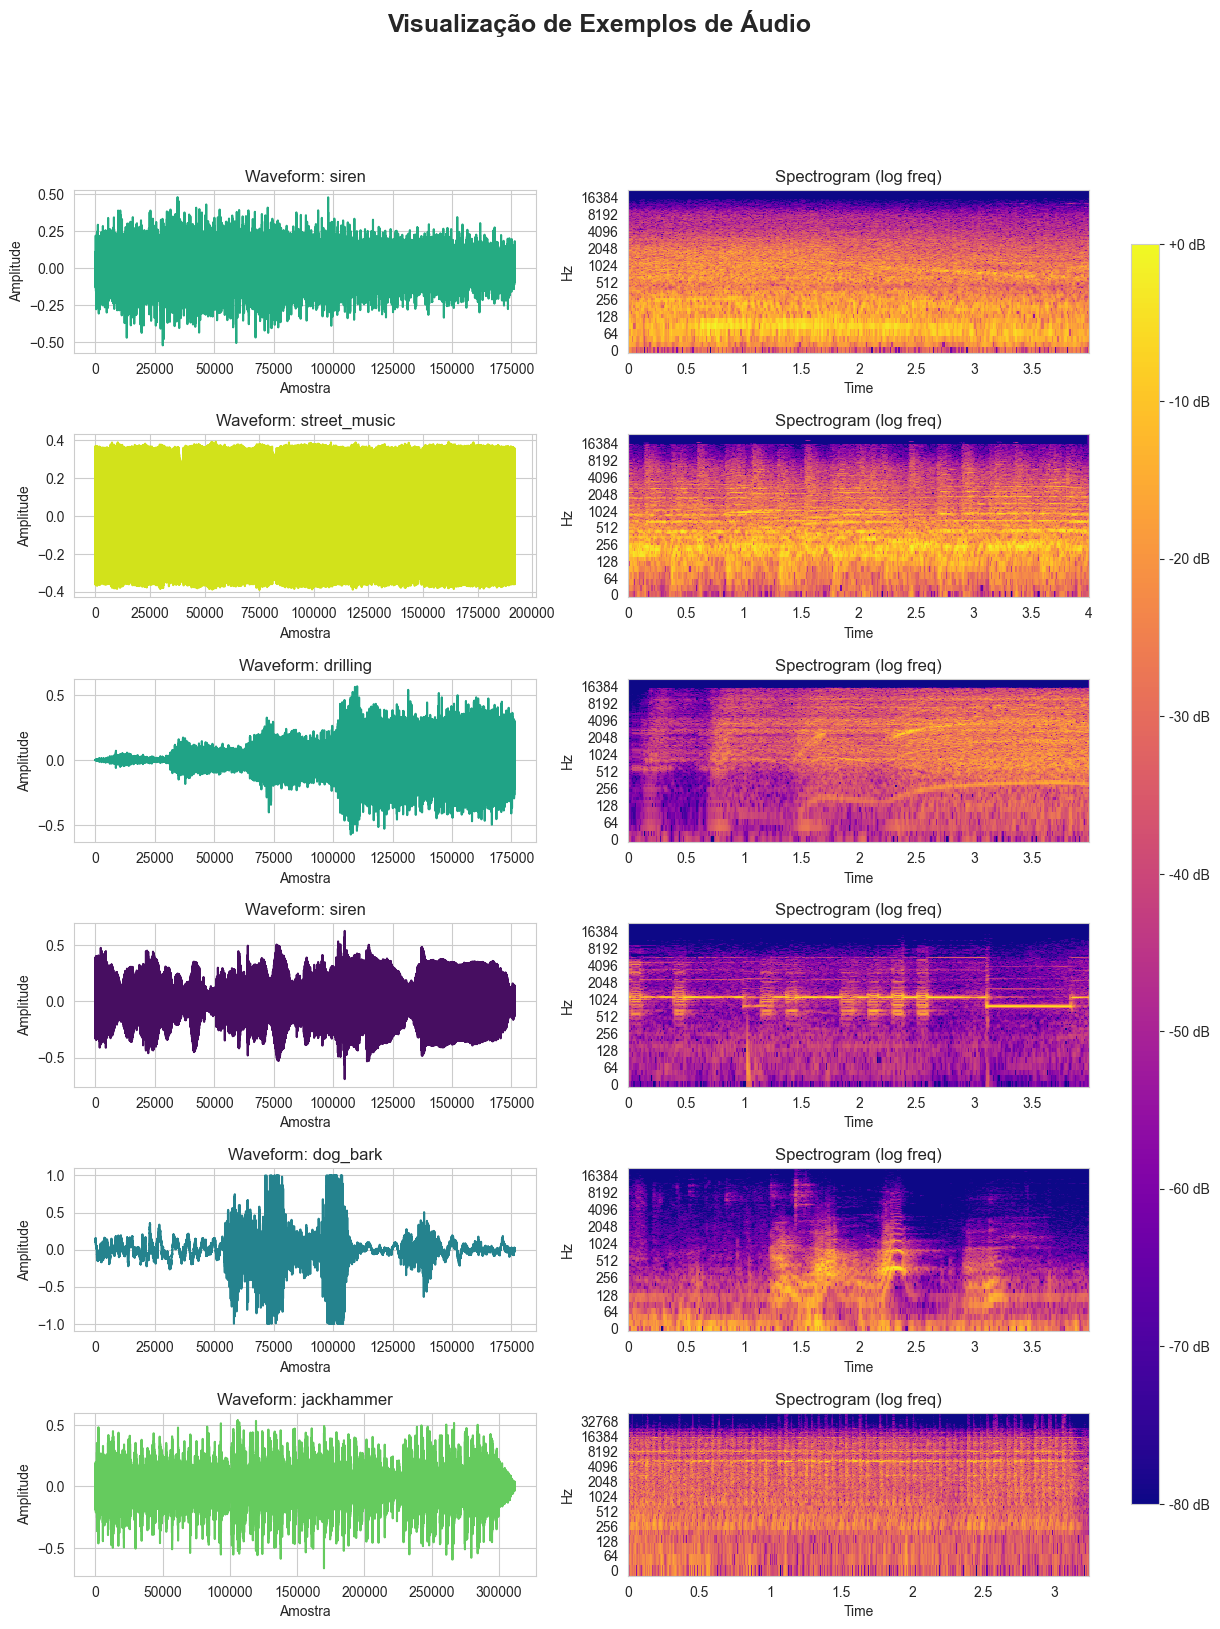

In [ ]:
# Explorando múltiplos exemplos de áudio do dataset

import random
import librosa.display

# Selecionar 6 exemplos aleatórios do dataset
sample_rows = metadata.sample(6, random_state=42)

fig, axes = plt.subplots(6, 2, figsize=(14, 18))
fig.suptitle("Visualização de Exemplos de Áudio", fontsize=18, weight='bold')

for i, (_, row) in enumerate(sample_rows.iterrows()):
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    waveform, sr = librosa.load(file_path, sr=None)
    
    # 🎨 Forma de onda com cor aleatória suave
    axes[i, 0].plot(waveform, color=plt.cm.viridis(random.random()))
    axes[i, 0].set_title(f"Waveform: {row['class']}", fontsize=12)
    axes[i, 0].set_xlabel("Amostra")
    axes[i, 0].set_ylabel("Amplitude")
    
    # 🔥 Espectrograma logarítmico
    S = librosa.stft(waveform)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', ax=axes[i, 1], cmap='plasma')
    axes[i, 1].set_title(f"Spectrogram (log freq)", fontsize=12)

# Ajuste de layout e colorbar
fig.subplots_adjust(right=0.85, hspace=0.5)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(img, cax=cbar_ax, format='%+2.0f dB')

plt.show()


### Interpretação do Waveform e Spectrograma

- **Waveform**: Mostra a amplitude do som ao longo do tempo. Picos indicam sons mais intensos, vales indicam sons mais suaves ou silêncio.  
- **Spectrograma**: Representa a intensidade do som em diferentes frequências ao longo do tempo. Cores mais fortes indicam maior energia em determinada frequência.

**Como isso ajuda na extração de features**:  
- Permite identificar padrões relevantes de cada classe de som.  
- Indica quais frequências e trechos temporais contêm mais informação, essenciais para calcular features como MFCCs ou Mel-spectrogramas.  
- Ajuda a decidir pré-processamentos úteis, como normalização e data augmentation.


Sons com padrões visuais distintos (por exemplo, “dog_bark” vs “siren”) facilitam a classificação automática.
Visualmente, já se consegue perceber se uma classe de som tende a ter energia concentrada em certas frequências ou períodos de tempo, o que orienta a escolha das features.

## Preprocessamento de Dados

## 2- Data Augumentation

#### 2.1 - Uniformizar a duração dos clipes e a taxa de amostragem

#### Por que escolhemos 22.050 Hz como taxa de amostragem

A **taxa de amostragem** (*sample rate*) indica quantas amostras de áudio são capturadas por segundo. Ela determina tanto a **qualidade do áudio** quanto a **faixa de frequências que podemos registrar**.  

De acordo com o **Teorema de Nyquist**, a maior frequência que podemos capturar é **metade da taxa de amostragem**.  
No caso de 22.050 Hz:

Ou seja, todas as frequências até 11.025 Hz são preservadas.

### Por que isso é suficiente para modelos de aprendizado de máquina

- A maior parte das informações importantes em sons (como fala, instrumentos ou efeitos sonoros) está nas **frequências baixas e médias**, abaixo de 11 kHz.  
- Reduzir a taxa de amostragem de arquivos originalmente maiores (44.100 Hz, 48 kHz, etc.) **diminui o tamanho dos dados** sem perder os padrões relevantes.  
- Isso **facilita o processamento**, seja para CNNs, MLPs ou outros modelos.



#### 2.2- Duração

Redes neurais convolucionais (CNNs) precisam receber dados com **relação espacial consistente**.  

- Em imagens, mudar a ordem das linhas ou colunas altera a informação e destrói a estrutura original.  
- Da mesma forma, no áudio, a relação entre **frequências e amplitudes ao longo do tempo** é essencial.  

Um dataset com durações diferentes significa **vetores de entrada de tamanhos variados**, o que não é compatível com CNNs.  

**Solução:** usamos **padding**:  
- Para amostras menores que a duração máxima do dataset, preenchemos o restante com **zeros**.  
- Esta técnica é muito comum e **não prejudica o desempenho da rede**, permitindo que todas as amostras tenham o mesmo tamanho.


#### 2.3 - Amplitude Máxima

É importante **normalizar a amplitude** dos arquivos de áudio.  
Isso garante que o modelo aprenda **padrões de forma consistente**, sem ser influenciado apenas pelo volume do som, e evita problemas com saturação das funções de ativação.

#### 2.4 - Profundidade de Bits (Bit Depth)

A **profundidade de bits** define a **resolução de cada amostra de áudio**.  
- Maior bit depth → mais detalhes e maior faixa dinâmica.  
- Menor bit depth → menos precisão e mais ruído perceptível.  

Converter bit depths **não é problemático**, de forma semelhante à conversão da taxa de amostragem.


#### 2.5 - Mono

Para consistência no dataset, todos os arquivos são convertidos para **mono**.  
- Isso garante que cada amostra tenha **uma única forma de onda**, facilitando o processamento por qualquer modelo (MLP ou CNN).  
- Evita complicações com múltiplos canais que poderiam alterar os padrões de áudio que a rede aprende.


In [6]:

def load_mono_resample_and_fix(file_path, target_sr=22050, target_duration=4.0):
    target_length = int(target_sr * target_duration)
    
    # Carrega áudio, garante mono e faz resampling
    waveform, sr = librosa.load(file_path, sr=target_sr, mono=True)
    
    # Ajusta duração (padding ou corte)
    if len(waveform) < target_length:
        waveform = np.pad(waveform, (0, target_length - len(waveform)), mode='constant')
    else:
        waveform = waveform[:target_length]
    
    # Normaliza valores para [-1, 1]
    if np.max(np.abs(waveform)) > 0:
        waveform = waveform / np.max(np.abs(waveform))
    
    return waveform, sr


In [9]:
audio_data = []

for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    
    # Carrega e processa áudio
    waveform, sr = load_mono_resample_and_fix(file_path, target_sr=22050, target_duration=4.0)
    duration = len(waveform) / sr
    
    # Adiciona ao dataset
    audio_data.append({
        "file": row['slice_file_name'],
        "fold": row['fold'],
        "class": row['class'],
        "waveform": waveform,
        "sr": sr,
        "duration": duration
    })

# Cria DataFrame final
audio_df = pd.DataFrame(audio_data)


100%|██████████| 8732/8732 [02:53<00:00, 50.45it/s]


In [12]:
print(audio_df.head())

print(audio_df.describe())

                 file  fold             class  \
0    100032-3-0-0.wav     5          dog_bark   
1  100263-2-0-117.wav     5  children_playing   
2  100263-2-0-121.wav     5  children_playing   
3  100263-2-0-126.wav     5  children_playing   
4  100263-2-0-137.wav     5  children_playing   

                                            waveform     sr  duration  
0  [-0.0035208412, -0.0050912397, -0.0047212285, ...  22050       4.0  
1  [0.10102415, 0.1341297, 0.085020825, 0.0867967...  22050       4.0  
2  [-0.1688533, -0.18749887, -0.099522546, -0.080...  22050       4.0  
3  [0.004630125, -0.0071468963, -0.041926064, -0....  22050       4.0  
4  [0.08385908, 0.28763315, 0.41862833, 0.3697775...  22050       4.0  
              fold       sr  duration
count  8732.000000   8732.0    8732.0
mean      5.385937  22050.0       4.0
std       2.846820      0.0       0.0
min       1.000000  22050.0       4.0
25%       3.000000  22050.0       4.0
50%       5.000000  22050.0       4.0
75%    

#### Extração de features para MLP


Um MLP espera vetores 1-D (fixos) por amostra. Como o áudio é uma sequência (tempo × frequência), transformamos cada clipe num vetor resumo de características que captem informação timbral e temporal (por exemplo: MFCCs agregados, energia, ZCR, centroid).

#### 1.1 - Mel-Frequency Cepstral Coefficients (MFCCs)

In [13]:
TARGET_SR = 22050
TARGET_DURATION = 4.0   # segundos
N_MFCC = 40
N_FFT = 2048
HOP_LENGTH = 512
RANDOM_STATE = 42


# Função: extrai features agregadas (1D vector) a partir de uma waveform
def extract_mlp_features(y, sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH):
    feats = []

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std  = np.std(mfcc, axis=1)
    feats.extend(mfcc_mean)
    feats.extend(mfcc_std)

    # MFCC deltas
    mfcc_delta = librosa.feature.delta(mfcc)
    delta_mean = np.mean(mfcc_delta, axis=1)
    delta_std  = np.std(mfcc_delta, axis=1)
    feats.extend(delta_mean)
    feats.extend(delta_std)

    # Spectral centroid, bandwidth, rolloff (mean + std)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    feats.append(np.mean(centroid)); feats.append(np.std(centroid))
    feats.append(np.mean(bandwidth)); feats.append(np.std(bandwidth))
    feats.append(np.mean(rolloff)); feats.append(np.std(rolloff))

    # RMS (energia) and ZCR (texture) - mean + std
    rms = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length)
    feats.append(np.mean(rms)); feats.append(np.std(rms))
    feats.append(np.mean(zcr)); feats.append(np.std(zcr))

    # Spectral contrast -> mean per band
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    feats.extend(np.mean(contrast, axis=1))

    # Chroma -> mean per bin
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    feats.extend(np.mean(chroma, axis=1))

    return np.array(feats, dtype=np.float32)

In [16]:
X_list = []
y_list = []

for idx, row in tqdm(audio_df.iterrows(), total=len(audio_df)):
    y = row["waveform"]     # áudio já preprocessado
    sr = row["sr"]          # sr já padronizado

    feat = extract_mlp_features(y, sr)
    X_list.append(feat)
    y_list.append(row["class"])

X = np.vstack(X_list)
y = np.array(y_list)

# Cria DataFrame com as features e a classe
feature_names = (
    [f"mfcc_mean_{i}" for i in range(N_MFCC)] +
    [f"mfcc_std_{i}" for i in range(N_MFCC)] +
    [f"delta_mean_{i}" for i in range(N_MFCC)] +
    [f"delta_std_{i}" for i in range(N_MFCC)] +
    ["centroid_mean", "centroid_std", "bandwidth_mean", "bandwidth_std", "rolloff_mean", "rolloff_std",
     "rms_mean", "rms_std", "zcr_mean", "zcr_std"] +
    [f"contrast_mean_{i}" for i in range(7)] +
    [f"chroma_mean_{i}" for i in range(12)]
)

MLP_features = pd.DataFrame(X, columns=feature_names)
MLP_features["class"] = y



100%|██████████| 8732/8732 [12:43<00:00, 11.44it/s]


In [17]:
# Exporta para CSV
MLP_features.to_csv("mlp_features.csv", index=False)
print("Features exportadas para mlp_features.csv")

Features exportadas para mlp_features.csv


## Extração de Features para CNN

Mel-Frequency Cepstral Coefficients (MFCCs)


In [ ]:
audio_df = pd.read_pickle("./processed_audio_data.pkl")

In [ ]:
TARGET_SR = 22050
TARGET_DURATION = 4.0         # segundos (tu já usas 4s)
TARGET_LEN = int(TARGET_SR * TARGET_DURATION)  # 88200
N_FFT = 2048
HOP = 512
N_MELS = 128

# número de frames esperado na dimensão tempo
N_FRAMES = 1 + (TARGET_LEN - N_FFT) // HOP
print("EXPECTED MEL FRAMES (n_frames) =", N_FRAMES)   # deverá dar 169

# pasta onde guardar os ficheiros pré-computados
OUT_DIR = "precomputed_mels"
os.makedirs(OUT_DIR, exist_ok=True)


# === FUNÇÕES DE EXTRAÇÃO ===
def waveform_to_log_mel(y, sr=TARGET_SR, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS, frames_max=N_FRAMES):
    """
    Recebe uma waveform (mono, resampled, padded/cropped para TARGET_LEN) e devolve S_db (n_mels, n_frames)
    com padding temporal central se necessário.
    """
    # assegura tipo float
    y = np.asarray(y, dtype=np.float32)
    # calcula mel power spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=2.0)
    # converte para dB (log-mel)
    S_db = librosa.power_to_db(S, ref=np.max)
    # se for mais curto em frames, aplica padding central
    if frames_max is not None and S_db.shape[1] < frames_max:
        diff = frames_max - S_db.shape[1]
        left = diff // 2
        right = diff - left
        S_db = np.pad(S_db, pad_width=((0,0),(left,right)), mode='constant', constant_values=(S_db.min(),))
    # se por algum motivo for maior: corta centralmente (não esperado se as waveforms já estão pad/crop)
    if frames_max is not None and S_db.shape[1] > frames_max:
        start = (S_db.shape[1] - frames_max)//2
        S_db = S_db[:, start:start+frames_max]
    return S_db.astype(np.float32)


def build_stack_from_waveform(y, sr=TARGET_SR, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS, frames_max=N_FRAMES):
    """
    Retorna stack numpy (3, n_mels, n_frames): [log-mel, delta1, delta2]
    """
    mel = waveform_to_log_mel(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, frames_max=frames_max)
    d1 = librosa.feature.delta(mel)
    d2 = librosa.feature.delta(mel, order=2)
    stacked = np.stack([mel, d1, d2], axis=0).astype(np.float32)
    return stacked


# === PIPELINE: usa audio_df (que tu já tens) e guarda .npz ===
# audio_df deve ter colunas: 'file' (slice_file_name), 'fold', 'class' (nome) e 'waveform', 'sr'
# metadata tem classID; vamos obter classID a partir do metadata dataframe
# Assumo que 'metadata' existe (tal como no teu notebook)

def precompute_and_save_npz(audio_df, metadata_df, out_dir=OUT_DIR, frames_max=N_FRAMES):
    """
    Extrai log-mel+delta+delta2 para cada linha de audio_df (usando waveform salvo aí) e guarda .npz.
    """
    missing = 0
    for i, row in tqdm(audio_df.iterrows(), total=len(audio_df), desc="precompute"):
        file_name = row['file']    # ex: '100032-3-0-0.wav'
        fold = int(row['fold'])
        # obtém classID do metadata (match por file e fold)
        m = metadata_df[(metadata_df['slice_file_name']==file_name) & (metadata_df['fold']==fold)]
        if len(m) == 0:
            # fallback: procura só pelo file (caso nomes diferentes)
            m = metadata_df[metadata_df['slice_file_name']==file_name]
        if len(m) == 0:
            missing += 1
            continue
        classID = int(m['classID'].values[0])
        # waveform já tem resample e padding (se tens audio_df)
        y = row['waveform']
        # sanity check length; se não tiveres pad, podes chamar load_mono_resample_and_fix aqui
        if len(y) != TARGET_LEN:
            # corrige automaticamente: pad ou crop
            if len(y) < TARGET_LEN:
                y = np.pad(y, (0, TARGET_LEN - len(y)), mode='constant')
            else:
                y = y[:TARGET_LEN]
        # constrói stack e salva
        stacked = build_stack_from_waveform(y, sr=TARGET_SR, frames_max=frames_max)
        base = f"fold{fold}_{file_name.replace('.wav','')}.npz"
        np.savez_compressed(os.path.join(out_dir, base), arr=stacked, classID=classID)
    if missing>0:
        print(f"Warning: {missing} rows not matched to metadata (verifica nomes/folds).")
    print("Done. Saved to", out_dir)


# === UTIL: check e visualizar um exemplo ===
def sanity_check_and_visualize(out_dir=OUT_DIR, example_idx=0):
    files = sorted([f for f in os.listdir(out_dir) if f.endswith('.npz')])
    if len(files)==0:
        print("No .npz files found in", out_dir); return
    p = os.path.join(out_dir, files[example_idx])
    data = np.load(p)
    arr = data['arr']   # (3, n_mels, n_frames)
    cls = int(data['classID'])
    print("Loaded:", files[example_idx], "shape:", arr.shape, "classID:", cls)
    plt.figure(figsize=(10,4))
    librosa.display.specshow(arr[0], sr=TARGET_SR, hop_length=HOP, x_axis='time', y_axis='mel')
    plt.title(f"Log-Mel (example) - {files[example_idx]}")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()



EXPECTED MEL FRAMES (n_frames) = 169


In [19]:
precompute_and_save_npz(audio_df, metadata, out_dir=OUT_DIR, frames_max=N_FRAMES)

precompute: 100%|██████████| 8732/8732 [04:51<00:00, 29.98it/s]

Done. Saved to precomputed_mels


Loaded: fold10_157207-6-1-0.npz shape: (3, 128, 169) classID: 6


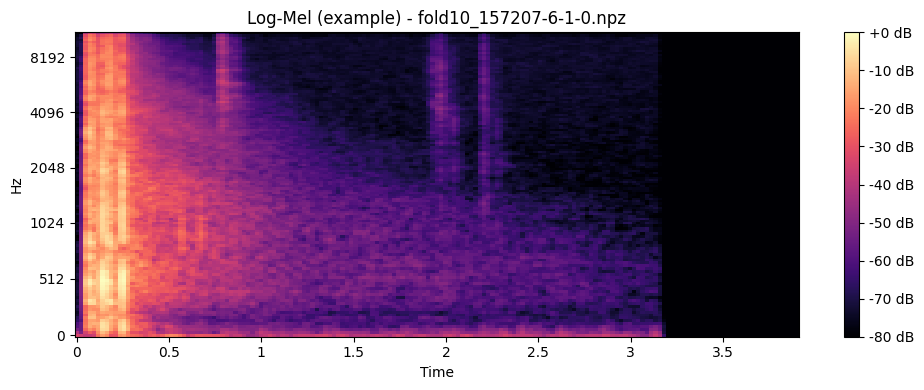

In [19]:
sanity_check_and_visualize(OUT_DIR, example_idx=200)

Referências:

- [Environmental sound classification with convolutional neural networks](https://ieeexplore.ieee.org/abstract/document/7324337)


In [103]:
AUDIO_PATH = "./precomputed_mels"

In [104]:
def load_audio(file_path, target_sr=16000, max_len=16000):
    y, sr = librosa.load(file_path, sr=target_sr)
    if len(y) > max_len:
        y = y[:max_len]
    else:
        y = np.pad(y, (0, max_len - len(y)))
    return np.expand_dims(y, axis=-1)  # (samples, 1)

In [ ]:
# Escolher qual fold será usado como validação
val_fold = 10
test_fold = 9

# Separar metadados
train_meta = metadata[(metadata["fold"] != val_fold) & (metadata["fold"] != test_fold)]
test_meta = metadata[metadata["fold"] == test_fold]
val_meta = metadata[metadata["fold"] == val_fold]

def build_dataset(meta_df):
    \"""
    Carrega os ficheiros .npz pré-computados que correspondem aos folds especificados.
    Retorna arrays (N, 3, n_mels, n_frames) e (N,) com os classIDs.
    \"""
    X, y = [], []
    
    for idx, row in tqdm(meta_df.iterrows(), total=len(meta_df), desc="Loading"):
        file_name = row['slice_file_name']
        fold = int(row['fold'])
        
        # Constrói o nome do ficheiro .npz correspondente
        base = f"fold{fold}_{file_name.replace('.wav', '')}.npz"
        file_path = os.path.join(AUDIO_PATH, base)
        
        # Verifica se existe
        if not os.path.exists(file_path):
            print(f"Warning: {file_path} not found, skipping...")
            continue
        
        # Carrega o .npz
        data = np.load(file_path)
        arr = data['arr']       # (3, n_mels, n_frames)
        classID = int(data['classID'])
        
        X.append(arr)
        y.append(classID)
    
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int64)

print("Carregando dados de treino...")
X_train, y_train = build_dataset(train_meta)

print("Carregando dados de teste...")
X_test, y_test = build_dataset(test_meta)

print("Carregando dados de validação...")
X_val, y_val = build_dataset(val_meta)

print(f"\nShapes finais:")
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Val:   X={X_val.shape}, y={y_val.shape}")
print(f"Test:  X={X_test.shape}, y={y_test.shape}")

In [ ]:
class CNN2D(tf.keras.Model):
    def __init__(self, num_classes=10, base=16):
        super().__init__()
        self.conv1 = tf.keras.Sequential([
            layers.Conv2D(base, 3, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2)
        ])
        self.conv2 = tf.keras.Sequential([
            layers.Conv2D(base*2, 3, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2)
        ])
        self.conv3 = tf.keras.Sequential([
            layers.Conv2D(base*4, 3, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2)
        ])
        self.conv4 = tf.keras.Sequential([
            layers.Conv2D(base*8, 3, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D()
        ])
        self.fc = layers.Dense(base*32, activation='relu')
        self.drop = layers.Dropout(0.4)
        self.out = layers.Dense(num_classes, activation='softmax')

    def call(self, x, training=False):
        x = self.conv1(x, training=training)
        x = self.conv2(x, training=training)
        x = self.conv3(x, training=training)
        x = self.conv4(x, training=training)
        x = self.fc(x)
        x = self.drop(x, training=training)
        return self.out(x)

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs disponíveis: {len(gpus)}")
    except RuntimeError as e:
        print(e)

# Limpar sessão anterior
tf.keras.backend.clear_session()


In [ ]:

# Configuração dos folds
VAL_FOLD = 10
TEST_FOLD = 9

# Construir listas de ficheiros .npz
AUDIO_PATH = "./precomputed_mels"

def get_files_by_fold(base_path, fold):
    """Retorna lista de ficheiros .npz de um fold específico"""
    pattern = os.path.join(base_path, f"fold{fold}_*.npz")
    files = glob.glob(pattern)
    return sorted(files)

def get_train_files(base_path, exclude_folds):
    """Retorna ficheiros de treino (todos exceto os folds excluídos)"""
    all_files = []
    for fold in range(1, 11):  # folds 1-10
        if fold not in exclude_folds:
            all_files.extend(get_files_by_fold(base_path, fold))
    return sorted(all_files)

# Criar as listas
train_files = get_train_files(AUDIO_PATH, exclude_folds=[VAL_FOLD, TEST_FOLD])
val_files = get_files_by_fold(AUDIO_PATH, VAL_FOLD)
test_files = get_files_by_fold(AUDIO_PATH, TEST_FOLD)

print(f"Train: {len(train_files)} ficheiros")
print(f"Val:   {len(val_files)} ficheiros")
print(f"Test:  {len(test_files)} ficheiros")

In [ ]:
def load_npz_tf(path):
    def _load(npz_path):
        # Converte tensor para string Python
        path_str = npz_path.numpy().decode('utf-8') if isinstance(npz_path, bytes) else npz_path.numpy()
        data = np.load(path_str, allow_pickle=False)
        arr = data['arr'].astype(np.float16)          # (3,128,169)
        arr = np.transpose(arr, (1,2,0))              # (128,169,3)
        y = data['classID'].astype(np.int32)
        return arr, y
    
    arr, y = tf.py_function(_load, [path], [tf.float16, tf.int32])
    arr.set_shape((128,169,3))
    y.set_shape(())
    return arr, y

def make_ds(files, batch=4, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(files)
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(files), 1000))
    ds = ds.map(load_npz_tf, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
train_ds = make_ds(train_files, batch=4, shuffle=True)
val_ds   = make_ds(val_files, batch=4, shuffle=False)
test_ds  = make_ds(test_files, batch=4, shuffle=False)

mixed_precision.set_global_policy('mixed_float16')

sample_x, _ = next(iter(train_ds))
model = CNN2D(num_classes=10, base=8)
model.build(sample_x.shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=64,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
    ]
)

model.evaluate(test_ds)

In [ ]:
y_true = []
y_pred_all = []

for x_batch, y_batch in test_ds:
    y_true.extend(y_batch.numpy())
    y_pred_batch = model.predict(x_batch, verbose=0)
    y_pred_all.extend(np.argmax(y_pred_batch, axis=1))

y_true = np.array(y_true)
y_pred_all = np.array(y_pred_all)
print(classification_report(y_true, y_pred_all, digits=4))

# plot training history

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['loss','test_loss'], loc='upper left')

plt.show()

# Evaluate the model

scores = model.evaluate(test_ds)

print("Test accuracy:",scores[1])

In [ ]:
y_true = []
y_pred_all = []
for x_batch, y_batch in val_ds:
    y_true.extend(y_batch.numpy())
    y_pred_batch = model.predict(x_batch, verbose=0)
    y_pred_all.extend(np.argmax(y_pred_batch, axis=1))

y_true = np.array(y_true)
y_pred_all = np.array(y_pred_all)
print(classification_report(y_true, y_pred_all, digits=4))

scores = model.evaluate(val_ds)

print("Test accuracy:",scores[1])

In [ ]:
model = CNN2D(num_classes=10, base=8)
model.build(sample_x.shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
    ]
)

model.evaluate(test_ds)

In [ ]:
y_true = []
y_pred_all = []

for x_batch, y_batch in test_ds:
    y_true.extend(y_batch.numpy())
    y_pred_batch = model.predict(x_batch, verbose=0)
    y_pred_all.extend(np.argmax(y_pred_batch, axis=1))

y_true = np.array(y_true)
y_pred_all = np.array(y_pred_all)
print(classification_report(y_true, y_pred_all, digits=4))

# plot training history

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['loss','test_loss'], loc='upper left')

plt.show()

# Evaluate the model

scores = model.evaluate(test_ds)

print("Test accuracy:",scores[1])

In [ ]:
class CNN2D_Improved(tf.keras.Model):
    def __init__(self, num_classes=10, base=32):
        super().__init__()
        
        # Blocos convolucionais mais profundos
        self.conv1 = tf.keras.Sequential([
            layers.Conv2D(base, 3, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(base, 3, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(2),
            layers.Dropout(0.25)
        ])
        
        self.conv2 = tf.keras.Sequential([
            layers.Conv2D(base*2, 3, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(base*2, 3, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(2),
            layers.Dropout(0.25)
        ])
        
        self.conv3 = tf.keras.Sequential([
            layers.Conv2D(base*4, 3, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(base*4, 3, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(2),
            layers.Dropout(0.3)
        ])
        
        self.conv4 = tf.keras.Sequential([
            layers.Conv2D(base*8, 3, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.GlobalAveragePooling2D()
        ])
        
        # Camadas densas com regularização
        self.fc1 = layers.Dense(512, activation='relu', 
                                kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.drop1 = layers.Dropout(0.5)
        self.fc2 = layers.Dense(256, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.drop2 = layers.Dropout(0.4)
        self.out = layers.Dense(num_classes, activation='softmax')

    def call(self, x, training=False):
        x = self.conv1(x, training=training)
        x = self.conv2(x, training=training)
        x = self.conv3(x, training=training)
        x = self.conv4(x, training=training)
        x = self.fc1(x)
        x = self.drop1(x, training=training)
        x = self.fc2(x)
        x = self.drop2(x, training=training)
        return self.out(x)

In [ ]:
model = CNN2D_Improved(num_classes=10, base=8)
model.build(sample_x.shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=16,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
    ]
)

model.evaluate(test_ds)

In [ ]:
y_true = []
y_pred_all = []

for x_batch, y_batch in test_ds:
    y_true.extend(y_batch.numpy())
    y_pred_batch = model.predict(x_batch, verbose=0)
    y_pred_all.extend(np.argmax(y_pred_batch, axis=1))

y_true = np.array(y_true)
y_pred_all = np.array(y_pred_all)
print(classification_report(y_true, y_pred_all, digits=4))

# plot training history

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['loss','test_loss'], loc='upper left')

plt.show()

# Evaluate the model

scores = model.evaluate(test_ds)

print("Test accuracy:",scores[1])

In [ ]:
# ...existing code...
class CNN1D_fixed(tf.keras.Model):
    def __init__(self, input_shape=(16000,1), num_classes=10, hidden_layers=5, kernel_size=9):
        super().__init__()
        self.blocks = []
        # bloco 1
        filters = 16
        self.blocks.append(tf.keras.Sequential([
            layers.Conv1D(filters, kernel_size, padding='same', activation='relu', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.MaxPooling1D(pool_size=4)
        ]))
        # blocos intermediários
        for i in range(1, hidden_layers-1):
            filters = 16 * (2**i)
            self.blocks.append(tf.keras.Sequential([
                layers.Conv1D(filters, kernel_size, padding='same', activation='relu'),
                layers.BatchNormalization(),
                layers.MaxPooling1D(pool_size=4)
            ]))
        # conv final (mantém dimensionalidade temporal)
        final_filters = 16 * (2**(hidden_layers-1))
        self.conv_last = layers.Conv1D(final_filters, kernel_size, padding='same', activation='relu')
        self.bn_last = layers.BatchNormalization()
        self.global_pool = layers.GlobalAveragePooling1D()
        # densas
        fc_units = 16 * (2**hidden_layers)
        self.fc1 = layers.Dense(fc_units, activation='relu')
        self.drop = layers.Dropout(0.4)
        self.out = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = inputs
        for blk in self.blocks:
            x = blk(x, training=training)
        x = self.conv_last(x)
        x = self.bn_last(x, training=training)
        x = self.global_pool(x)
        x = self.fc1(x)
        x = self.drop(x, training=training)
        return self.out(x)

class CNN2D_matched(tf.keras.Model):
    def __init__(self, input_shape=(64, 157, 1), num_classes=10, base_filters=8):
        super().__init__()
        # arquitetura 2D com profundidade similar em parâmetros
        self.conv1 = tf.keras.Sequential([
            layers.Conv2D(base_filters, (3,3), padding='same', activation='relu', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2,2))
        ])
        self.conv2 = tf.keras.Sequential([
            layers.Conv2D(base_filters*2, (3,3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2,2))
        ])
        self.conv3 = tf.keras.Sequential([
            layers.Conv2D(base_filters*4, (3,3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2,2))
        ])
        
        self.conv_last = tf.keras.Sequential([
            layers.Conv2D(base_filters*2, (3,3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D()
        ])
        # densas alinhadas ao modelo 1D
        fc_units = base_filters*32  # 16 * 2**5 = 512 quando base_filters=16
        self.fc1 = layers.Dense(fc_units, activation='relu')
        self.drop = layers.Dropout(0.4)
        self.out = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.conv1(inputs, training=training)
        x = self.conv2(x, training=training)
        x = self.conv3(x, training=training)
        x = self.conv_last(x, training=training)
        x = self.fc1(x)
        x = self.drop(x, training=training)
        return self.out(x)

# utilitário rápido para comparar contagem de parâmetros
def params_count(model, example_input_shape):
    m = model
    m.build((None,)+example_input_shape)
    return m.count_params()

# exemplo de uso (instancie e veja parâmetros)
#cnn1 = CNN1D_fixed(input_shape=(16000,1))
#cnn2 = CNN2D_matched(input_shape=(64,157,1))  # 64 mel bins × ~157 frames para 1s@16000 com hop≈100
#print("CNN1D params:", params_count(cnn1, (16000,1)))
#print("CNN2D params:", params_count(cnn2, (64,157,1)))
# ...existing code...

In [ ]:

class FoldDatasetBuilder:
    def __init__(self, base_path, val_fold=10, test_fold=9, batch_size=16):
        self.base_path = base_path
        self.val_fold = val_fold
        self.test_fold = test_fold
        self.batch_size = batch_size
        
    def get_files_by_fold(self, fold):
        pattern = os.path.join(self.base_path, f"fold{fold}_*.npz")
        return sorted(glob.glob(pattern))
    
    def build_datasets(self):
        # Treino: todos os folds exceto val e test
        train_files = []
        for fold in range(1, 11):
            if fold not in [self.val_fold, self.test_fold]:
                train_files.extend(self.get_files_by_fold(fold))
        
        val_files = self.get_files_by_fold(self.val_fold)
        test_files = self.get_files_by_fold(self.test_fold)
        
        print(f"Configuração: Val=fold{self.val_fold}, Test=fold{self.test_fold}")
        print(f"Train: {len(train_files)} ficheiros")
        print(f"Val:   {len(val_files)} ficheiros")
        print(f"Test:  {len(test_files)} ficheiros")
        
        train_ds = make_ds(train_files, batch=self.batch_size, shuffle=True)
        val_ds = make_ds(val_files, batch=self.batch_size, shuffle=False)
        test_ds = make_ds(test_files, batch=self.batch_size, shuffle=False)
        
        return train_ds, val_ds, test_ds

# Uso:
builder = FoldDatasetBuilder(
    base_path="./precomputed_mels",
    val_fold=10,
    test_fold=9,
    batch_size=16
)

train_ds, val_ds, test_ds = builder.build_datasets()

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_all)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

In [ ]:
# plot training history

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['loss','test_loss'], loc='upper left')

plt.show()

# Evaluate the model

scores = model.evaluate(test_ds)

print("Test accuracy:",scores[1])

In [ ]:
model = CNN1D_fixed(input_shape=X_train.shape[2:], num_classes=10)

# Compilar
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Treinar
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=32,
          callbacks=[
              tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
              tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5)
          ])

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Relatório detalhado
print(classification_report(y_test, y_pred_classes, digits=4))

## Merge do dataset das features com o ficheiro de audio

In [127]:
# Adiciona coluna 'file' ao MLP_features
MLP_features['file'] = audio_df['file'].values  

# Faz merge apenas UMA vez para adicionar 'fold' e 'classID'
MLP_features = MLP_features.merge(
    metadata[['slice_file_name', 'fold', 'classID']],
    left_on='file', right_on='slice_file_name', how='left'
)

# Renomeia todas as colunas auxiliares para nomes únicos e consistentes
for df in [MLP_features]:
    for col in df.columns:
        if col.startswith('fold'):
            df.rename(columns={col: 'fold'}, inplace=True)
        if col.startswith('classID'):
            df.rename(columns={col: 'classID'}, inplace=True)
        if col.startswith('slice_file_name'):
            df.rename(columns={col: 'slice_file_name'}, inplace=True)

# Remove colunas auxiliares do merge
MLP_features = MLP_features.drop(columns=['slice_file_name'])

# Remove colunas duplicadas se existirem 
MLP_features = MLP_features.loc[:, ~MLP_features.columns.duplicated()]


In [128]:
print(MLP_features.columns)
print(MLP_features.head())

Index(['mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3',
       'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7',
       'mfcc_mean_8', 'mfcc_mean_9',
       ...
       'chroma_mean_6', 'chroma_mean_7', 'chroma_mean_8', 'chroma_mean_9',
       'chroma_mean_10', 'chroma_mean_11', 'class', 'file', 'fold', 'classID'],
      dtype='object', length=193)
   mfcc_mean_0  mfcc_mean_1  mfcc_mean_2  mfcc_mean_3  mfcc_mean_4  \
0  -590.823181     5.574052   -10.476468    -5.272372    -1.054818   
1   -62.527626    99.336624   -42.995586    51.073326     9.853778   
2   -46.742538   112.362534   -37.578075    43.195866     8.631845   
3   -69.774872    91.196602   -25.043558    42.784519    11.586844   
4   -26.328707   103.862228   -42.658783    50.690285    12.209422   

   mfcc_mean_5  mfcc_mean_6  mfcc_mean_7  mfcc_mean_8  mfcc_mean_9  ...  \
0    -2.363346    -0.301927     1.025405     1.102500     0.668602  ...   
1     7.969693    11.197088     1.929118     7.030397     

## Feature Selection MLP
#### No caso do CNN, não é recomendado fazer um feature selection previamente ao treino como no caso do MLP, porque o objetivo do CNN é justamente aprender automaticamente as melhores features a partir do espectrograma completo (ou seja, da matriz 3×128×169), se não a estrutura espacial/temporal dos dados seria eliminada.

#### Começamos por fazer um estudo das features extraidas para o MLP

In [129]:
feature_cols = [col for col in MLP_features.columns if col not in ["class", "file", "fold", "classID"]]
X = MLP_features[feature_cols]
y = MLP_features["class"]

# Verifica colunas com qualquer valor NaN
nan_cols = X.columns[X.isna().any()].tolist()
if nan_cols:
    print("Colunas com NaN:", nan_cols)
else:
    print("Nenhuma coluna com NaN.")

# Verifica colunas com valores constantes (variância zero)
const_cols = [col for col in X.columns if X[col].nunique() == 1]
if const_cols:
    print("Colunas com valor constante:", const_cols)
else:
    print("Nenhuma coluna com valor constante.")

# 2. Remover features com variância muito baixa (não informativas)
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=1e-5)
X_reduced = selector.fit_transform(X)
selected_columns = X.columns[selector.get_support(indices=True)]
removed_columns = X.columns[~selector.get_support()]

print("Colunas removidas por baixa variância:", list(removed_columns))
print("Shape após VarianceThreshold:", X_reduced.shape)
print("Features selecionadas:", list(selected_columns))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[selected_columns])

Nenhuma coluna com NaN.
Nenhuma coluna com valor constante.
Colunas removidas por baixa variância: []
Shape após VarianceThreshold: (8732, 189)
Features selecionadas: ['mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12', 'mfcc_mean_13', 'mfcc_mean_14', 'mfcc_mean_15', 'mfcc_mean_16', 'mfcc_mean_17', 'mfcc_mean_18', 'mfcc_mean_19', 'mfcc_mean_20', 'mfcc_mean_21', 'mfcc_mean_22', 'mfcc_mean_23', 'mfcc_mean_24', 'mfcc_mean_25', 'mfcc_mean_26', 'mfcc_mean_27', 'mfcc_mean_28', 'mfcc_mean_29', 'mfcc_mean_30', 'mfcc_mean_31', 'mfcc_mean_32', 'mfcc_mean_33', 'mfcc_mean_34', 'mfcc_mean_35', 'mfcc_mean_36', 'mfcc_mean_37', 'mfcc_mean_38', 'mfcc_mean_39', 'mfcc_std_0', 'mfcc_std_1', 'mfcc_std_2', 'mfcc_std_3', 'mfcc_std_4', 'mfcc_std_5', 'mfcc_std_6', 'mfcc_std_7', 'mfcc_std_8', 'mfcc_std_9', 'mfcc_std_10', 'mfcc_std_11', 'mfcc_std_12', 'mfcc_std_13', 'm

### Ranking e Seleção de Features para o dataset de treino com recurso ao ANOVA F-Test

In [130]:
# ANOVA F-test
f_values, p_values = f_classif(X_scaled, y)

# Ranking das features (do maior para o menor F-score)
feature_ranking = np.argsort(f_values)[::-1]
ranked_features = X.columns[feature_ranking]

# Top 10 melhores
print("Top 10 features pelo ANOVA F-test:")
for i in range(10):
    print(f"{i+1}. {ranked_features[i]} (F={f_values[feature_ranking[i]]:.2f}, p={p_values[feature_ranking[i]]:.2e})")

# Top 10 piores
print("\n10 piores features pelo ANOVA F-test:")
for i in range(1, 11):
    idx = -i
    print(f"{len(ranked_features)+idx+1}. {ranked_features[idx]} (F={f_values[feature_ranking[idx]]:.2f}, p={p_values[feature_ranking[idx]]:.2e})")

# Remove apenas features com F-score abaixo do 1º quartil
f_q1 = np.percentile(f_values, 25)
selected_mask = f_values > f_q1
X_selected_features_25 = X.columns[selected_mask]
removed_features = X.columns[~selected_mask]


print(f"\nNúmero de features selecionadas para treino: {len(X_selected_features_25)}")
print(f"Selecionadas: {list(X_selected_features_25)}")
print(f"\nNúmero de features removidas: {len(removed_features)}")
print(f"Removidas: {list(removed_features)}")


Top 10 features pelo ANOVA F-test:
1. delta_std_3 (F=845.07, p=0.00e+00)
2. delta_std_2 (F=720.23, p=0.00e+00)
3. rms_mean (F=673.69, p=0.00e+00)
4. delta_std_23 (F=659.81, p=0.00e+00)
5. mfcc_mean_0 (F=659.43, p=0.00e+00)
6. delta_std_22 (F=640.87, p=0.00e+00)
7. delta_std_27 (F=633.73, p=0.00e+00)
8. mfcc_std_1 (F=633.50, p=0.00e+00)
9. delta_std_35 (F=627.62, p=0.00e+00)
10. delta_std_33 (F=619.93, p=0.00e+00)

10 piores features pelo ANOVA F-test:
189. delta_mean_21 (F=0.35, p=9.57e-01)
188. delta_mean_31 (F=0.57, p=8.24e-01)
187. delta_mean_18 (F=0.87, p=5.50e-01)
186. delta_mean_19 (F=1.42, p=1.73e-01)
185. delta_mean_29 (F=1.95, p=4.15e-02)
184. delta_mean_22 (F=1.97, p=3.82e-02)
183. delta_mean_14 (F=2.18, p=2.07e-02)
182. delta_mean_20 (F=2.29, p=1.46e-02)
181. delta_mean_4 (F=2.30, p=1.41e-02)
180. delta_mean_36 (F=2.43, p=9.32e-03)

Número de features selecionadas para treino: 141
Selecionadas: ['mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc

In [131]:
# Remove features com F-score abaixo da mediana (percentil 50)
f_q2 = np.percentile(f_values, 50)
selected_mask = f_values > f_q2
X_selected_features_50 = X.columns[selected_mask]
removed_features = X.columns[~selected_mask]
print(f"Número de features selecionadas: {len(X_selected_features_50)}")

Número de features selecionadas: 94


In [132]:
# Remove features com F-score abaixo do 3º quartil (percentil 75)
f_q3 = np.percentile(f_values, 75)
selected_mask = f_values > f_q3
X_selected_features_75 = X.columns[selected_mask]
removed_features = X.columns[~selected_mask]
print(f"Número de features selecionadas: {len(X_selected_features_75)}")

Número de features selecionadas: 47


## Arquitetura do MLP

In [133]:
class AudioMLP(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.15),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),

            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),

            nn.Linear(32, num_classes)
        )

        # Xavier initialization
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)  # inicializa pesos
            if m.bias is not None:
                nn.init.zeros_(m.bias) 

    def forward(self, x):
        return self.model(x)

## Treino MLP

In [146]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------------------------------------
# 1. Função: separar os FOLDS (train / val / test)
# ------------------------------------------------------
def prepare_folds(df, test_fold, features_list):
    val_fold = (test_fold % 10) + 1
    train_folds = [f for f in range(1, 11) if f not in [test_fold, val_fold]]

    train_idx = df["fold"].isin(train_folds)
    val_idx   = df["fold"] == val_fold
    test_idx  = df["fold"] == test_fold

    X_train = df.loc[train_idx, features_list].values
    y_train = df.loc[train_idx, "classID"].values
    X_val   = df.loc[val_idx, features_list].values
    y_val   = df.loc[val_idx, "classID"].values
    X_test  = df.loc[test_idx, features_list].values
    y_test  = df.loc[test_idx, "classID"].values

    return X_train, y_train, X_val, y_val, X_test, y_test


In [147]:
# ------------------------------------------------------
# 2. Normalização (fit só no treino!)
# ------------------------------------------------------
def scale_sets(X_train, X_val, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)
    return X_train, X_val, X_test

In [148]:
# ------------------------------------------------------
# 3. Criar DataLoaders
# ------------------------------------------------------
def create_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64):
    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.long))
    val_ds   = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                             torch.tensor(y_val, dtype=torch.long))
    test_ds  = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=256)
    test_loader  = DataLoader(test_ds, batch_size=256)

    return train_loader, val_loader, test_loader

In [ ]:
# ------------------------------------------------------
# 4. Treinar um fold com early stopping
# ------------------------------------------------------
def train_one_fold(model, train_loader, val_loader, class_weights=None, max_epochs=30):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    if class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()
        
    best_state = None
    best_val_acc = 0

    for epoch in range(max_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                logits = model(xb)
                preds = logits.argmax(1).cpu().numpy()
                y_true.extend(yb.numpy())
                y_pred.extend(preds)

        val_acc = accuracy_score(y_true, y_pred)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

In [150]:
# ------------------------------------------------------
# 5. Testar um fold
# ------------------------------------------------------
def evaluate(model, test_loader, num_classes=10):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = logits.argmax(1).cpu().numpy()
            y_true.extend(yb.numpy())
            y_pred.extend(preds)

    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    conf = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

    return acc, f1_macro, conf

In [151]:
# -----------------------------
# 6. Plot da matriz de confusão cumulativa
# -----------------------------
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Cumulative Confusion Matrix (10-fold CV)')
    plt.show()

In [155]:
# --------------------------------
# 6. Cross-validation 
# --------------------------------
def cross_validate(df, features_list, model_class, num_classes=10):
    folds = sorted(df["fold"].unique())
    all_confusion = np.zeros((num_classes, num_classes), dtype=int)
    accuracies = []
    f1_scores = []

    for test_fold in folds:
        print(f"\n=== FOLD {test_fold}/10 ===")
        X_train, y_train, X_val, y_val, X_test, y_test = prepare_folds(df, test_fold, features_list)
        X_train, X_val, X_test = scale_sets(X_train, X_val, X_test)
        train_loader, val_loader, test_loader = create_loaders(X_train, y_train, X_val, y_val, X_test, y_test)

        # Calcule os class weights para o fold atual
        class_weights_np = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

        model = model_class(input_dim=X_train.shape[1], num_classes=num_classes).to(device)
        model = train_one_fold(model, train_loader, val_loader, class_weights=class_weights)

        acc, f1_macro, conf = evaluate(model, test_loader)
        accuracies.append(acc)
        f1_scores.append(f1_macro)
        all_confusion += conf

        print(f"Fold {test_fold} Accuracy: {acc:.4f}, F1-score (macro): {f1_macro:.4f}")

    print("\n============================")
    print("Cross-validation concluída:")
    print(f"Average Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Average F1-score (macro): {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print("============================")

    return accuracies, f1_scores, all_confusion

## Treino do MLP sem feature selection


=== FOLD 1/10 ===
Fold 1 Accuracy: 0.6220, F1-score (macro): 0.6364

=== FOLD 2/10 ===
Fold 2 Accuracy: 0.6441, F1-score (macro): 0.6583

=== FOLD 3/10 ===
Fold 3 Accuracy: 0.6281, F1-score (macro): 0.6518

=== FOLD 4/10 ===
Fold 4 Accuracy: 0.6798, F1-score (macro): 0.6684

=== FOLD 5/10 ===
Fold 5 Accuracy: 0.7724, F1-score (macro): 0.7842

=== FOLD 6/10 ===
Fold 6 Accuracy: 0.6889, F1-score (macro): 0.7109

=== FOLD 7/10 ===
Fold 7 Accuracy: 0.7267, F1-score (macro): 0.7155

=== FOLD 8/10 ===
Fold 8 Accuracy: 0.6538, F1-score (macro): 0.6490

=== FOLD 9/10 ===
Fold 9 Accuracy: 0.6789, F1-score (macro): 0.6769

=== FOLD 10/10 ===
Fold 10 Accuracy: 0.7491, F1-score (macro): 0.7652

Cross-validation concluída:
Average Accuracy: 0.6844 ± 0.0484
Average F1-score (macro): 0.6917 ± 0.0482


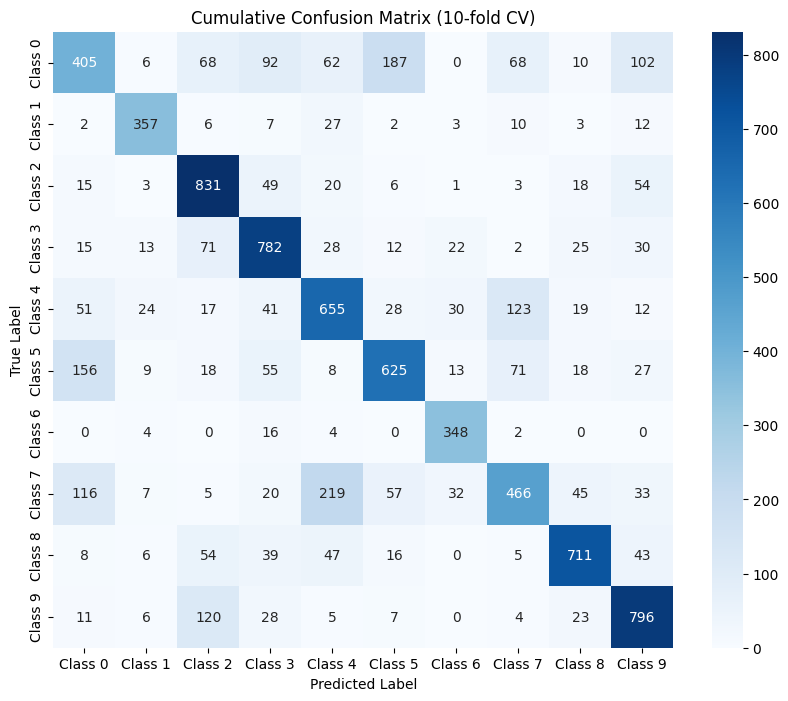

In [162]:
accuracies, f1_scores, conf_mat = cross_validate(
    df=MLP_features,
    features_list=list(selected_columns),
    model_class=AudioMLP,
    num_classes=10
)
class_names = [f"Class {i}" for i in range(10)]
plot_confusion_matrix(conf_mat, class_names)

### Treino do MLP Feature Selection (Percentil 25)


=== FOLD 1/10 ===
Fold 1 Accuracy: 0.6541, F1-score (macro): 0.6708

=== FOLD 2/10 ===
Fold 2 Accuracy: 0.7083, F1-score (macro): 0.7151

=== FOLD 3/10 ===
Fold 3 Accuracy: 0.6476, F1-score (macro): 0.6711

=== FOLD 4/10 ===
Fold 4 Accuracy: 0.6838, F1-score (macro): 0.6698

=== FOLD 5/10 ===
Fold 5 Accuracy: 0.7393, F1-score (macro): 0.7332

=== FOLD 6/10 ===
Fold 6 Accuracy: 0.7181, F1-score (macro): 0.7364

=== FOLD 7/10 ===
Fold 7 Accuracy: 0.6766, F1-score (macro): 0.6676

=== FOLD 8/10 ===
Fold 8 Accuracy: 0.7184, F1-score (macro): 0.7251

=== FOLD 9/10 ===
Fold 9 Accuracy: 0.7034, F1-score (macro): 0.7108

=== FOLD 10/10 ===
Fold 10 Accuracy: 0.7682, F1-score (macro): 0.7825

Cross-validation concluída:
Average Accuracy: 0.7018 ± 0.0355
Average F1-score (macro): 0.7082 ± 0.0363


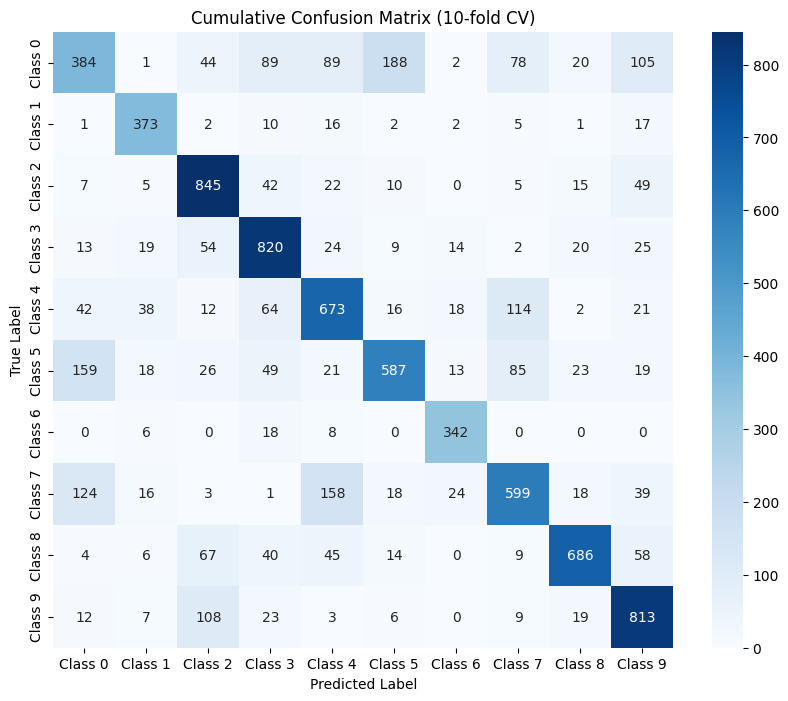

In [159]:
accuracies, f1_scores, conf_mat = cross_validate(
    df=MLP_features,
    features_list=list(X_selected_features_25),
    model_class=AudioMLP,
    num_classes=10
)
class_names = [f"Class {i}" for i in range(10)]
plot_confusion_matrix(conf_mat, class_names)

### Treino do MLP Feature Selection (Percentil 50)


=== FOLD 1/10 ===
Fold 1 Accuracy: 0.6919, F1-score (macro): 0.7126

=== FOLD 2/10 ===
Fold 2 Accuracy: 0.6689, F1-score (macro): 0.6807

=== FOLD 3/10 ===
Fold 3 Accuracy: 0.6519, F1-score (macro): 0.6417

=== FOLD 4/10 ===
Fold 4 Accuracy: 0.6949, F1-score (macro): 0.6855

=== FOLD 5/10 ===
Fold 5 Accuracy: 0.7596, F1-score (macro): 0.7631

=== FOLD 6/10 ===
Fold 6 Accuracy: 0.6282, F1-score (macro): 0.6396

=== FOLD 7/10 ===
Fold 7 Accuracy: 0.6205, F1-score (macro): 0.6432

=== FOLD 8/10 ===
Fold 8 Accuracy: 0.5906, F1-score (macro): 0.5871

=== FOLD 9/10 ===
Fold 9 Accuracy: 0.6863, F1-score (macro): 0.6852

=== FOLD 10/10 ===
Fold 10 Accuracy: 0.7312, F1-score (macro): 0.7395

Cross-validation concluída:
Average Accuracy: 0.6724 ± 0.0489
Average F1-score (macro): 0.6778 ± 0.0496


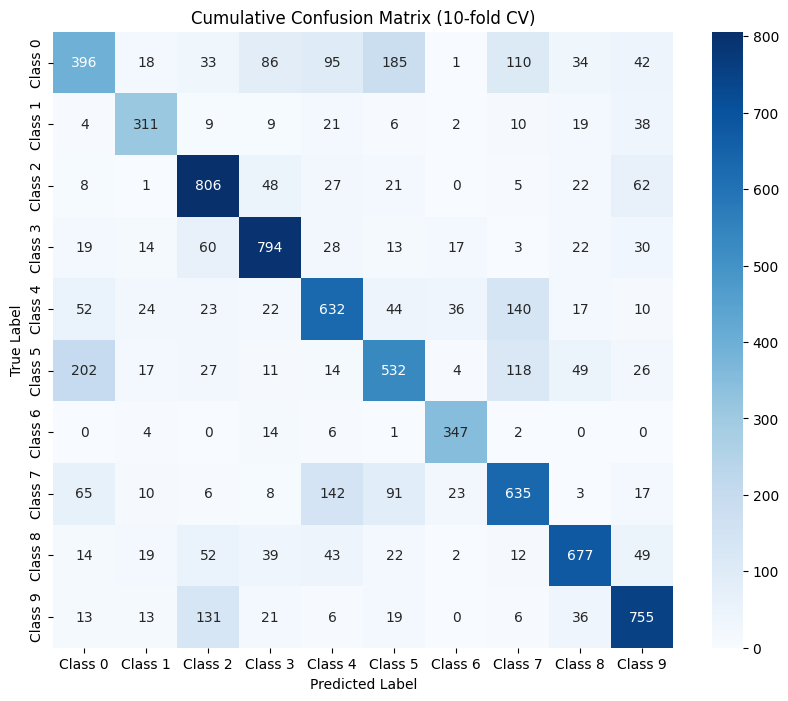

In [160]:
accuracies, f1_scores, conf_mat = cross_validate(
    df=MLP_features,
    features_list=list(X_selected_features_50),
    model_class=AudioMLP,
    num_classes=10
)
class_names = [f"Class {i}" for i in range(10)]
plot_confusion_matrix(conf_mat, class_names)

### Treino do MLP Feature Selection (Percentil 75)


=== FOLD 1/10 ===
Fold 1 Accuracy: 0.5945, F1-score (macro): 0.5966

=== FOLD 2/10 ===
Fold 2 Accuracy: 0.5957, F1-score (macro): 0.5994

=== FOLD 3/10 ===
Fold 3 Accuracy: 0.6000, F1-score (macro): 0.6123

=== FOLD 4/10 ===
Fold 4 Accuracy: 0.5970, F1-score (macro): 0.5882

=== FOLD 5/10 ===
Fold 5 Accuracy: 0.6517, F1-score (macro): 0.6643

=== FOLD 6/10 ===
Fold 6 Accuracy: 0.6173, F1-score (macro): 0.6408

=== FOLD 7/10 ===
Fold 7 Accuracy: 0.6229, F1-score (macro): 0.6297

=== FOLD 8/10 ===
Fold 8 Accuracy: 0.6154, F1-score (macro): 0.6249

=== FOLD 9/10 ===
Fold 9 Accuracy: 0.6569, F1-score (macro): 0.6594

=== FOLD 10/10 ===
Fold 10 Accuracy: 0.7097, F1-score (macro): 0.7055

Cross-validation concluída:
Average Accuracy: 0.6261 ± 0.0350
Average F1-score (macro): 0.6321 ± 0.0346


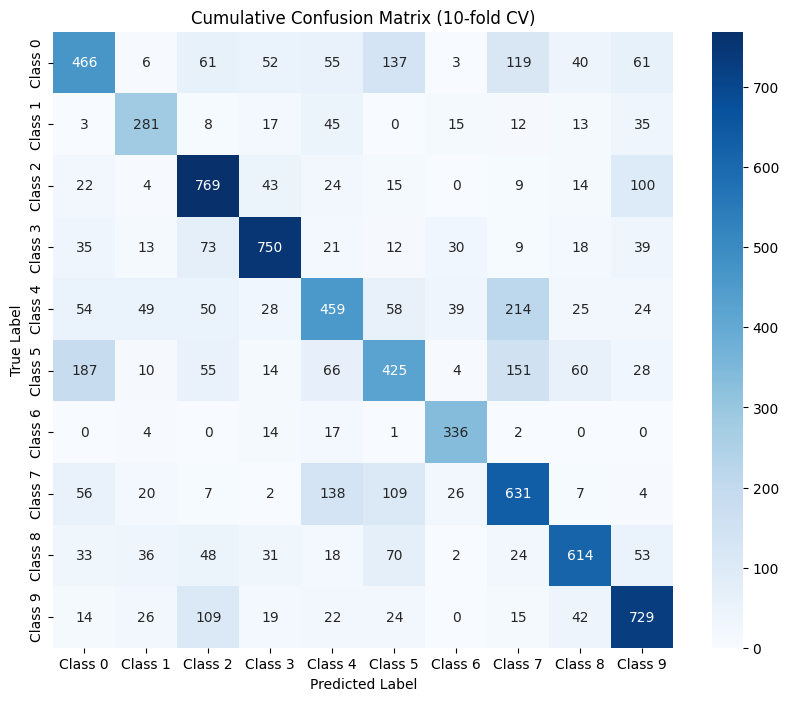

In [161]:
accuracies, f1_scores, conf_mat = cross_validate(
    df=MLP_features,
    features_list=list(X_selected_features_75),
    model_class=AudioMLP,
    num_classes=10
)
class_names = [f"Class {i}" for i in range(10)]
plot_confusion_matrix(conf_mat, class_names)

## Conclusões: o melhor modelo